In [1]:
class Node:
    def __init__(self, data, depth=0, lchild=None, rchild=None):
        self.data = data
        self.depth = depth
        self.lchild = lchild
        self.rchild = rchild
class KdTree:
    def __init__(self):
        self.KdTree = None
        self.n = 0
        self.nearest = None

    def create(self, dataSet, depth=0):
        if len(dataSet) > 0:
            m, n = np.shape(dataSet)
            self.n = n - 1
            axis = depth % self.n
            mid = int(m / 2)
            dataSetcopy = sorted(dataSet, key=lambda x: x[axis])
            node = Node(dataSetcopy[mid], depth)
            if depth == 0:
                self.KdTree = node
            node.lchild = self.create(dataSetcopy[:mid], depth+1)
            node.rchild = self.create(dataSetcopy[mid+1:], depth+1)
            return node
        return None

    def preOrder(self, node):
        if node is not None:
            print(node.depth, node.data)
            self.preOrder(node.lchild)
            self.preOrder(node.rchild)

    def search(self, x, count=1):
        nearest = []
        for i in range(count):
            nearest.append([-1, None])
        self.nearest = np.array(nearest)

        def recurve(node):
            if node is not None:
                axis = node.depth % self.n
                daxis = x[axis] - node.data[axis]
                if daxis < 0:
                    recurve(node.lchild)
                else:
                    recurve(node.rchild)

                dist = sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(x, node.data)))
                for i, d in enumerate(self.nearest):
                    if d[0] < 0 or dist < d[0]:
                        self.nearest = np.insert(self.nearest, i, [dist, node], axis=0)
                        self.nearest = self.nearest[:-1]
                        break

                n = list(self.nearest[:, 0]).count(-1)
                if self.nearest[-n-1, 0] > abs(daxis):
                    if daxis < 0:
                        recurve(node.rchild)
                    else:
                        recurve(node.lchild)

        recurve(self.KdTree)

        knn = self.nearest[:, 1]
        belong = []
        for i in knn:
            belong.append(i.data[-1])
        b = max(set(belong), key=belong.count)

        return self.nearest, b

In [2]:
%%time
import numpy as np
from math import sqrt
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = iris.target
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']

dist2=[]
data2=np.array(df.drop('label',axis=1))
for m in range(0,len(data2)):
    for n in range(m+1,len(data2)):
         dist2.append(sqrt(sum((data[m] - data[n]) ** 2 )))
a = np.percentile(dist2,10) #密度阈值（10%分位数）

x1 = np.array([[1,1],[1,-1]])
x2 = np.array([1,np.floor(7 / 3)/ 7])
(Ps_,Pd_)=np.linalg.solve(x1,x2)
H_ = -Ps_* np.log2(Ps_)-Pd_*np.log2(Pd_) #标签混合程度阈值
F_list,Re_list=[],[]
for rate in[0.05,0.1,0.2,0.3,0.4]:
    P,R,F1,Re=[],[],[],[]
    for term in range(10):

        aa=df[df.label==0].sample(frac=rate, replace=False) #选取噪声比例
        bb=df[df.label==1].sample(frac=rate, replace=False) #选取噪声比例
        cc=df[df.label==2].sample(frac=rate, replace=False) #选取噪声比例
        noise_set=pd.concat([aa,bb,cc],axis=0)
        data_cut=df[~df.index.isin(noise_set.index)]
        no=[]
        for j in range(0,len(noise_set)):
            no.append(int(np.random.rand(1)[0]*3)%10)
        noise_set['label2']=no
        noise_set.reset_index(drop=True,inplace=True)
        for l in range(0,len(noise_set)):  #随机替换标签
            if (noise_set.loc[l,'label']==noise_set.loc[l,'label2']):
                noise_set.loc[l,'label2']=(noise_set.loc[l,'label']+1) % 3
        noise=noise_set.drop(['label'],axis=1)
        noise.rename(columns={'label2':'label'}, inplace = True)
        data= pd.concat([data_cut,noise],axis=0,ignore_index=True) #含噪声数据集

        data=np.array(data)
        kdt = KdTree()
        kdt.create(data)
       # kdt.preOrder(kdt.KdTree)

        print('epoch..........:',term)
        Dn = []
        for x in data:
            #plt.scatter(x[0], x[1], c='red', marker='x')  # 测试点
            near, belong = kdt.search(x[:-1], 8)  # 设置临近点的个数
            #print("test:")
           # print(x, "predict:", belong)
           # print("nearest:")
            density = 0
            t = 0
            for n in near:
                #print(n[1].data, "dist:", n[0])
                #plt.scatter(n[1].data[0], n[1].data[1], c='green', marker='+')  # k个最近邻点
                density += n[0]  #密度
                if (x[-1] == n[1].data[-1])&(x != n[1].data)is True:
                    t += 1
            Ps = t / 7
            Pd = 1 - Ps
            if (Ps==1)|(Ps==0):
                H = 0
            else:
                H = -Ps* np.log2(Ps)-Pd*np.log2(Pd)

           # print(densit)
            if (density <= a): #高密度区域
                if x[-1] != belong:
                    Dn.append(list(x))
                    #print('高密度区域噪声')

            else:
                if (H <= H_): #低密度单一标签区域
                    if x[-1] != belong:
                        Dn.append(list(x))
                       # print('H:',H)
                       # print('低密度单一区域噪声')
                else: #低密度混合标签区域
                    hon,hen= -1,0
                    dist_hon,dist_hen = 0,0
                    for n in near:
                        if x[-1]==n[-1].data[-1]:
                            hon += 1
                            dist_hon += n[0]
                        else:
                            hen +=1
                            dist_hen += n[0]
                    if (dist_hon / hon) / (dist_hen / hen) > 1.2:
                        Dn.append(list(x))
                       # print('H:',H)
                       # print('低密度混合标签区域噪声')

        #print('标签噪声：',Dn)
        noise_list=noise.values.tolist()
        TP = 0
        for c in Dn:
            if c in noise_list:
                TP += 1
        FP = len(Dn) - TP
        FN = len(noise_list) - TP
        precision= TP / (TP + FP)
        recall= TP / (TP + FN)
        f1=2 * (precision * recall) / (precision + recall)
        P.append(precision) #准确率
        R.append(recall)#召回率
        F1.append(f1) #F1值
        Re.append(len(Dn) / len(data)) #移除率
    print(rate*100,'%','噪声下:')
    print('准确率:',np.mean(P))
    print('召回率:',np.mean(R))
    print('F1值:',np.mean(F1))
    print('移除率:',np.mean(Re))
    F_list.append(np.mean(F1))
    Re_list.append(np.mean(Re))

NameError: name 'data' is not defined

In [3]:
import mpl_toolkits.axisartist.axislines as axislines
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

NameError: name 'F_list' is not defined

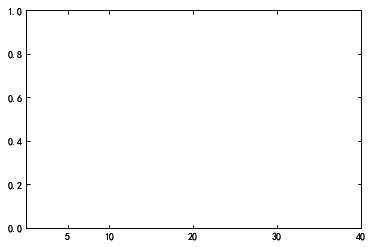

In [4]:
noise_rate=[5,10,20,30,40]
fig = plt.figure()
ax1 = axislines.Subplot(fig, 1,1,1)
fig.add_subplot(ax1)
ax1.set_xticks(noise_rate)
ax1.axis([0,40,0,1])
plt.plot(noise_rate,F_list,'ro-')
plt.xlabel('噪声比例/%')
plt.ylabel('F1')
plt.title('不同噪声下的F1值')
plt.show()

In [ ]:
fig2 = plt.figure()
ax2 = axislines.Subplot(fig2, 1,1,1)
fig2.add_subplot(ax2)
ax2.set_xticks([5,10,20,30,40])
ax2.set_yticks([0,0.2,0.4,0.6,0.8])
ax2.axis([0,40,0,0.8])
plt.plot(noise_rate,Re_list,'b*-')
plt.plot(noise_rate,Re_list,'b*-')
plt.xlabel('噪声比例/%')
plt.ylabel('Re')
plt.title('不同噪声下的过滤值Re')
plt.show()